In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Step 2: PCA / POD

In [2]:
import numpy as np
from numpy import linalg as LA
import pyfftw
import matplotlib.pyplot as plt

In [3]:
###############################################################################
#POD Routines
###############################################################################         
def POD(u,R): #Basis Construction
    n,ns = u.shape
    U,S,Vh = LA.svd(u, full_matrices=False)
    Phi = U[:,:R]  
    L = S**2
    #compute RIC (relative inportance index)
    RIC = sum(L[:R])/sum(L)*100   
    return Phi,L,RIC

def PODproj(u,Phi): #Projection
    a = np.dot(u.T,Phi)  # u = Phi * a.T
    return a

def PODrec(a,Phi): #Reconstruction    
    u = np.dot(Phi,a.T)    
    return u

In [4]:
def fpsi(nx, ny, dx, dy, f):
    epsilon = 1.0e-6
    aa = -2.0/(dx*dx) - 2.0/(dy*dy)
    bb = 2.0/(dx*dx)
    cc = 2.0/(dy*dy)
    hx = 2.0*np.pi/np.float64(nx)
    hy = 2.0*np.pi/np.float64(ny)
    
    kx = np.empty(nx)
    ky = np.empty(ny)
    
    kx[:] = hx*np.float64(np.arange(0, nx))

    ky[:] = hy*np.float64(np.arange(0, ny))
    
    kx[0] = epsilon
    ky[0] = epsilon

    kx, ky = np.meshgrid(np.cos(kx), np.cos(ky), indexing='ij')
    
    data = np.empty((nx,ny), dtype='complex128')
    data1 = np.empty((nx,ny), dtype='complex128')
    
    data[:,:] = np.vectorize(complex)(f,0.0)

    a = pyfftw.empty_aligned((nx,ny),dtype= 'complex128')
    b = pyfftw.empty_aligned((nx,ny),dtype= 'complex128')
    
    fft_object = pyfftw.FFTW(a, b, axes = (0,1), direction = 'FFTW_FORWARD')
    fft_object_inv = pyfftw.FFTW(a, b,axes = (0,1), direction = 'FFTW_BACKWARD')
    
    e = fft_object(data)
    #e = pyfftw.interfaces.scipy_fftpack.fft2(data)
    
    e[0,0] = 0.0
    
    data1[:,:] = e[:,:]/(aa + bb*kx[:,:] + cc*ky[:,:])

    ut = np.real(fft_object_inv(data1))
        
    return ut

In [5]:
#%% Main program:
# Inputs
nx =  256   #spatial grid number
ny = 256    #spatial grid number
nc = 4      #number of control parameters (nu)
ns = 200    #number of snapshot per each Parameter 
nr = 8      #number of modes
Re_start = 200.0 #Lower range of Reynods number
Re_final = 800.0 #Upper range of Reynolds number
Re  = np.linspace(Re_start, Re_final, nc) #control Reynolds
nu = 1/Re   #control dissipation
lx = 2.0*np.pi
ly = 2.0*np.pi
dx = lx/nx
dy = ly/ny
dt = 1e-1
tm = 20.0
ReTest = 500
training = 'true'

In [6]:
#%% Data generation for training
x = np.linspace(0, lx, nx+1)
y = np.linspace(0, ly, ny+1)
t = np.linspace(0, tm, ns+1)

um = np.zeros(((nx)*(ny), ns+1, nc))
up = np.zeros(((nx)*(ny), ns+1, nc))
uo = np.zeros(((nx)*(ny), ns+1, nc))

for p in range(0,nc):
    for n in range(0,ns+1):
        file_input = "./snapshots/Re_"+str(int(Re[p]))+"/w/w_"+str(int(n))+ ".csv"
        w = np.genfromtxt(file_input, delimiter=',')
        
        w1 = w[1:nx+1,1:ny+1]
        
        um[:,n,p] = np.reshape(w1,(nx)*(ny)) #snapshots from unperturbed solution
        uo[:,n,p] = um[:,n,p] 

In [7]:
#%% POD basis computation
PHIw = np.zeros(((nx)*(ny),nr,nc))
PHIs = np.zeros(((nx)*(ny),nr,nc))        
       
L = np.zeros((ns+1,nc)) #Eigenvalues      
RIC = np.zeros((nc))    #Relative information content

print('Computing POD basis for vorticity ...')
for p in range(0,nc):
    u = uo[:,:,p]
    PHIw[:,:,p], L[:,p], RIC[p]  = POD(u, nr) 

PHIw = PHIw/(np.sign(PHIw[0,:,:]))

Computing POD basis for vorticity ...


In [8]:
#%%    
print('Computing POD basis for streamfunction ...')
for p in range(0,nc):
    for i in range(nr):
        phi_w = np.reshape(PHIw[:,i,p],[nx,ny])
        phi_s = fpsi(nx, ny, dx, dy, -phi_w)
        PHIs[:,i,p] = np.reshape(phi_s,(nx)*(ny))

Computing POD basis for streamfunction ...


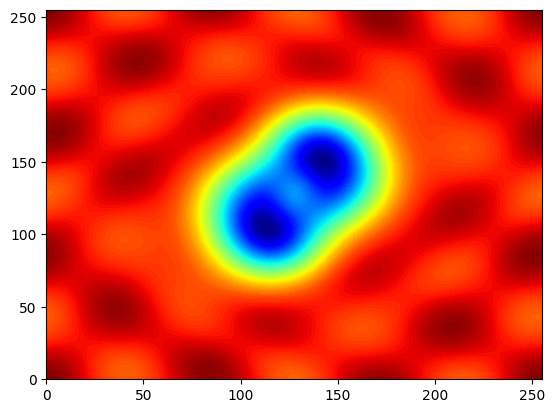

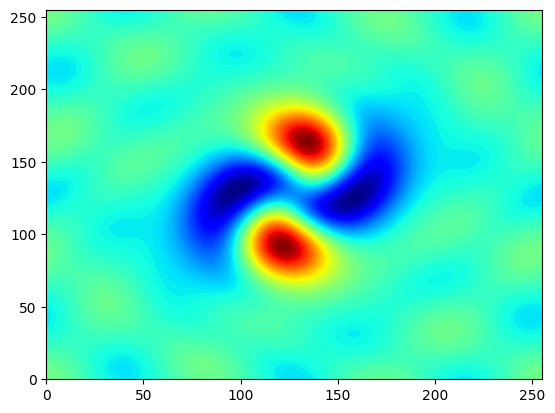

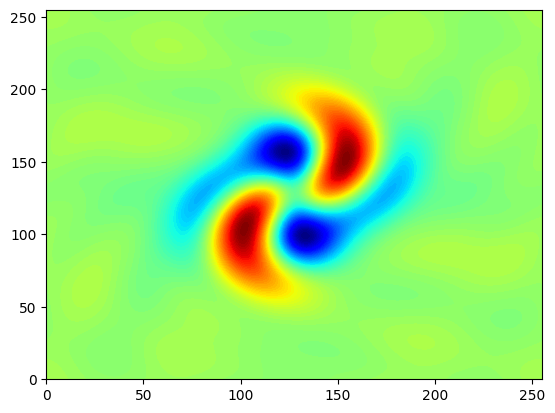

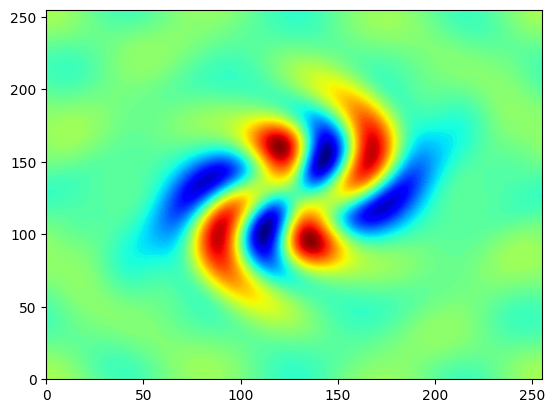

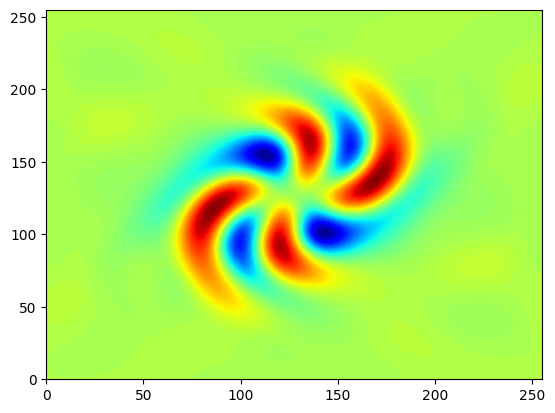

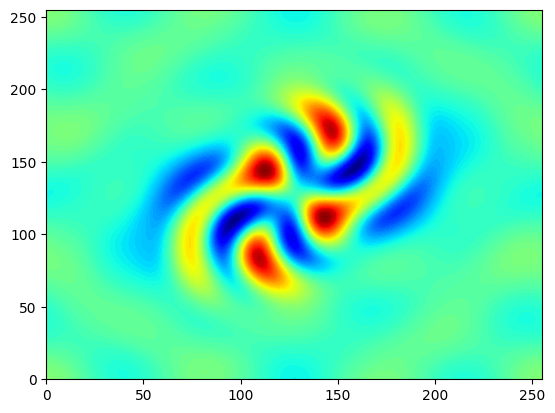

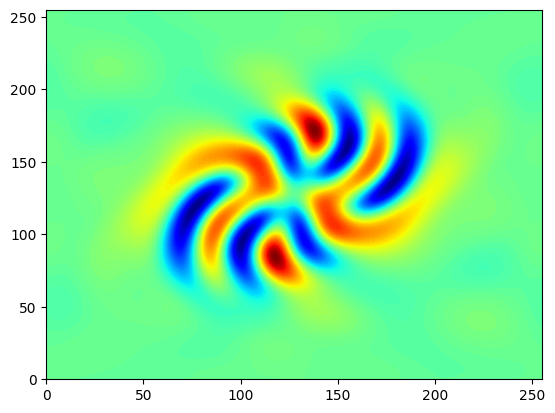

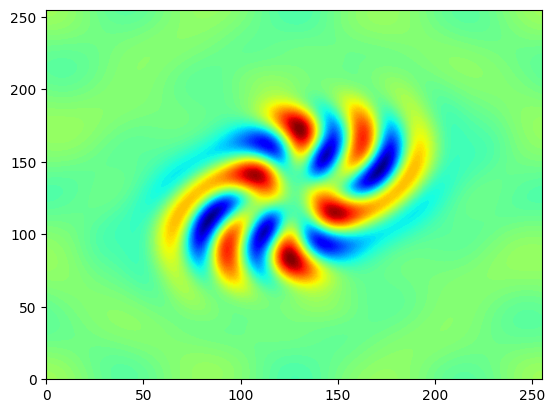

In [9]:
Phi=PHIw.reshape(nx,ny,8,4)
for i in range(0,8):
    plt.contourf(Phi[:,:,i,0],120, cmap = 'jet')
    plt.savefig("./Phi_" + str(int(i))+".png", bbox_inches = 'tight')
    plt.show()

In [10]:
def linear_term(nx,ny,dx,dy,re,f):
    w = np.zeros((nx+3,ny+3))
    
    w[1:nx+1,1:ny+1] = f
    
    # periodic
    w[:,ny+1] = w[:,1]
    w[nx+1,:] = w[1,:]
    w[nx+1,ny+1] = w[1,1]
    
    # ghost points
    w[:,0] = w[:,ny]
    w[:,ny+2] = w[:,2]
    w[0,:] = w[nx,:]
    w[nx+2,:] = w[2,:]
    
    aa = 1.0/(dx*dx)
    bb = 1.0/(dy*dy)
    
    f = np.zeros((nx+1,ny+1))
    
    lap = aa*(w[2:nx+3,1:ny+2]-2.0*w[1:nx+2,1:ny+2]+w[0:nx+1,1:ny+2]) \
        + bb*(w[1:nx+2,2:ny+3]-2.0*w[1:nx+2,1:ny+2]+w[1:nx+2,0:ny+1])
    
    f = lap/re
            
    return f[1:nx+1,1:ny+1]

def pbc(w):
    f = np.zeros((nx+1,ny+1))
    f[:nx,:ny] = w
    f[:,ny] = f[:,0]
    f[nx,:] = f[0,:]
    
    return f

In [11]:
def nonlinear_term(nx,ny,dx,dy,wf,sf):
    '''
    this function returns -(Jacobian)
    
    '''
    w = np.zeros((nx+3,ny+3))
    
    w[1:nx+1,1:ny+1] = wf
    
    # periodic
    w[:,ny+1] = w[:,1]
    w[nx+1,:] = w[1,:]
    w[nx+1,ny+1] = w[1,1]
    
    # ghost points
    w[:,0] = w[:,ny]
    w[:,ny+2] = w[:,2]
    w[0,:] = w[nx,:]
    w[nx+2,:] = w[2,:]
    
    s = np.zeros((nx+3,ny+3))
    
    s[1:nx+1,1:ny+1] = sf
    
    # periodic
    s[:,ny+1] = s[:,1]
    s[nx+1,:] = s[1,:]
    s[nx+1,ny+1] = s[1,1]
    
    # ghost points
    s[:,0] = s[:,ny]
    s[:,ny+2] = s[:,2]
    s[0,:] = s[nx,:]
    s[nx+2,:] = s[2,:]
    
    gg = 1.0/(4.0*dx*dy)
    hh = 1.0/3.0
    
    f = np.zeros((nx+1,ny+1))
    
    #Arakawa
    j1 = gg*( (w[2:nx+3,1:ny+2]-w[0:nx+1,1:ny+2])*(s[1:nx+2,2:ny+3]-s[1:nx+2,0:ny+1]) \
             -(w[1:nx+2,2:ny+3]-w[1:nx+2,0:ny+1])*(s[2:nx+3,1:ny+2]-s[0:nx+1,1:ny+2]))

    j2 = gg*( w[2:nx+3,1:ny+2]*(s[2:nx+3,2:ny+3]-s[2:nx+3,0:ny+1]) \
            - w[0:nx+1,1:ny+2]*(s[0:nx+1,2:ny+3]-s[0:nx+1,0:ny+1]) \
            - w[1:nx+2,2:ny+3]*(s[2:nx+3,2:ny+3]-s[0:nx+1,2:ny+3]) \
            + w[1:nx+2,0:ny+1]*(s[2:nx+3,0:ny+1]-s[0:nx+1,0:ny+1]))

    j3 = gg*( w[2:nx+3,2:ny+3]*(s[1:nx+2,2:ny+3]-s[2:nx+3,1:ny+2]) \
            - w[0:nx+1,0:ny+1]*(s[0:nx+1,1:ny+2]-s[1:nx+2,0:ny+1]) \
            - w[0:nx+1,2:ny+3]*(s[1:nx+2,2:ny+3]-s[0:nx+1,1:ny+2]) \
            + w[2:nx+3,0:ny+1]*(s[2:nx+3,1:ny+2]-s[1:nx+2,0:ny+1]) )

    f = -(j1+j2+j3)*hh
                  
    return f[1:nx+1,1:ny+1]

In [12]:
#%% Galerkin projection [Fully Intrusive]

###############################
# Galerkin projection with nr
###############################
b_l = np.zeros((nr,nr,nc))
b_nl = np.zeros((nr,nr,nr,nc))
linear_phi = np.zeros(((nx)*(ny),nr,nc))
nonlinear_phi = np.zeros(((nx)*(ny),nr,nc))

# linear term   
for p in range(nc):
    for i in range(nr):
        phi_w = np.reshape(PHIw[:,i,p],[nx,ny])
        
        lin_term = linear_term(nx,ny,dx,dy,Re[p],phi_w)
        linear_phi[:,i,p] = np.reshape(lin_term,(nx)*(ny))

for p in range(nc):
    for k in range(nr):
        for i in range(nr):
            b_l[i,k,p] = np.dot(linear_phi[:,i,p].T , PHIw[:,k,p]) 
                   
# nonlinear term 
for p in range(nc):
    for i in range(nr):
        phi_w = np.reshape(PHIw[:,i,p],[nx,ny])
        for j in range(nr):  
            phi_s = np.reshape(PHIs[:,j,p],[nx,ny])
            nonlin_term = nonlinear_term(nx,ny,dx,dy,phi_w,phi_s)
            jacobian_phi = np.reshape(nonlin_term,(nx)*(ny))
            for k in range(nr):    
                b_nl[i,j,k,p] = np.dot(jacobian_phi.T, PHIw[:,k,p]) 

In [13]:
def rhs(nr, b_l, b_nl, a): # Right Handside of Galerkin Projection
    r2, r3, r = [np.zeros(nr) for _ in range(3)]
    
    for k in range(nr):
        r2[k] = 0.0
        for i in range(nr):
            r2[k] = r2[k] + b_l[i,k]*a[i]
    
    for k in range(nr):
        r3[k] = 0.0
        for j in range(nr):
            for i in range(nr):
                r3[k] = r3[k] + b_nl[i,j,k]*a[i]*a[j]
    
    r = r2 + r3    
    return r

In [14]:
###############################################################################
#Interpolation Routines
###############################################################################  
# Grassmann Interpolation
def GrassInt(Phi,pref,p,pTest):
    # Phi is input basis [training]
    # pref is the reference basis [arbitrarty] for Grassmann interpolation
    # p is the set of training parameters
    # pTest is the testing parameter
    
    nx,nr,nc = Phi.shape
    Phi0 = Phi[:,:,pref] 
    Phi0H = Phi0.T 

    print('Calculating Gammas...')
    Gamma = np.zeros((nx,nr,nc))
    for i in range(nc):
        templ = Phi[:,:,i] - LA.multi_dot([Phi0,Phi0H,Phi[:,:,i]])
        tempr = LA.inv( np.dot(Phi0H,Phi[:,:,i]) )
        temp = np.dot(templ, tempr)
                       
        U, S, Vh = LA.svd(temp, full_matrices=False)
        S = np.diag(S)
        Gamma[:,:,i] = LA.multi_dot([U,np.arctan(S),Vh])
    
    print('Interpolating ...')
    alpha = np.ones(nc)
    GammaL = np.zeros((nx,nr))
    #% Lagrange Interpolation
    for i in range(nc):
        for j in range(nc):
            if (j != i) :
                alpha[i] = alpha[i]*(pTest-p[j])/(p[i]-p[j])
    for i in range(nc):
        GammaL = GammaL + alpha[i] * Gamma[:,:,i]
            
    U, S, Vh = LA.svd(GammaL, full_matrices=False)
    PhiL = LA.multi_dot([ Phi0 , Vh.T ,np.diag(np.cos(S)) ]) + \
           LA.multi_dot([ U , np.diag(np.sin(S)) ])
    PhiL = PhiL.dot(Vh)
    return PhiL

# Reduced Order Model

In [15]:
#%% Testing
uTest = np.zeros((nx*ny, ns+1))
upTest = np.zeros((nx*ny, ns+1))
uoTest = np.zeros((nx*ny, ns+1))
nuTest = 1/ReTest

for n in range(ns+1):
   file_input = "./snapshots/Re_"+str(int(ReTest))+"/w/w_"+str(int(n))+ ".csv"
   w = np.genfromtxt(file_input, delimiter=',')
    
   w1 = w[1:nx+1,1:ny+1]
    
   uTest[:,n] = np.reshape(w1,(nx)*(ny)) #snapshots from unperturbed solution
   uoTest[:,n] = uTest[:,n] 

#%%   
w_fom = uoTest[:,-1] # last time step
w_fom = np.reshape(w_fom,[nx,ny])
w_fom = pbc(w_fom)

In [16]:
#% POD basis computation     
print('Computing testing POD basis...')
PHItrue, Ltrue, RICtrue  = POD(uoTest, nr) 
PHItrue = PHItrue/np.sign(PHItrue[0,:])

#% Calculating true POD coefficients
print('Computing testing POD coefficients...')
aTrue = PODproj(uoTest,PHItrue)

Computing testing POD basis...
Computing testing POD coefficients...


In [17]:
#%% Basis Interpolation
pref = 3 #Reference case in [0:nRe]
PHIwtest = GrassInt(PHIw,pref,nu,nuTest)
PHIwtest = PHIwtest/np.sign(PHIwtest[0,:])
aTest = PODproj(uoTest,PHIwtest)

Calculating Gammas...
Interpolating ...


In [18]:
print('Reconstructing with true coefficients for test Re')
w_test = PODrec(aTest[:,:],PHIwtest[:,:])

Reconstructing with true coefficients for test Re


In [19]:
w_test.shape

(65536, 201)

In [20]:
w_test = w_test[:,-1]
w_test = np.reshape(w_test,[nx,ny])

In [21]:
PHIstest = np.zeros(((nx)*(ny),nr))

for i in range(nr):
    phi_w = np.reshape(PHIwtest[:,i],[nx,ny])
    phi_s = fpsi(nx, ny, dx, dy, -phi_w)    
    PHIstest[:,i] = np.reshape(phi_s,(nx)*(ny))
b_l = np.zeros((nr,nr))
b_nl = np.zeros((nr,nr,nr))
linear_phi = np.zeros(((nx)*(ny),nr))
nonlinear_phi = np.zeros(((nx)*(ny),nr))
 
for k in range(nr):
    phi_w = np.reshape(PHIwtest[:,k],[nx,ny])
    lin_term = linear_term(nx,ny,dx,dy,ReTest,phi_w)
    linear_phi[:,k] = np.reshape(lin_term,(nx)*(ny))

for k in range(nr):
    for i in range(nr):
        b_l[i,k] = np.dot(linear_phi[:,i].T , PHIwtest[:,k]) 
                   
for i in range(nr):
    phi_w = np.reshape(PHIwtest[:,i],[nx,ny])
    for j in range(nr):  
        phi_s = np.reshape(PHIstest[:,j],[nx,ny])
        nonlin_term = nonlinear_term(nx,ny,dx,dy,phi_w,phi_s)
        jacobian_phi = np.reshape(nonlin_term,(nx)*(ny))
        for k in range(nr):    
            b_nl[i,j,k] = np.dot(jacobian_phi.T, PHIwtest[:,k]) 

In [22]:
aGPtest = np.zeros((ns+1,nr))
aGPtest[0,:] = aTest[0,:nr]
aGPtest[1,:] = aTest[1,:nr]
aGPtest[2,:] = aTest[2,:nr]
for k in range(3,ns+1):
    r1 = rhs(nr, b_l[:,:], b_nl[:,:,:], aGPtest[k-1,:])
    r2 = rhs(nr, b_l[:,:], b_nl[:,:,:], aGPtest[k-2,:])
    r3 = rhs(nr, b_l[:,:], b_nl[:,:,:], aGPtest[k-3,:])
    temp= (23/12) * r1 - (16/12) * r2 + (5/12) * r3
    aGPtest[k,:] = aGPtest[k-1,:] + dt*temp 

In [23]:
print('Reconstructing with GP coefficients for test Re')
w_gp = PODrec(aGPtest[:,:],PHIwtest[:,:])
w_gp = w_gp[:,-1]
w_gp = np.reshape(w_gp,[nx,ny])

Reconstructing with GP coefficients for test Re


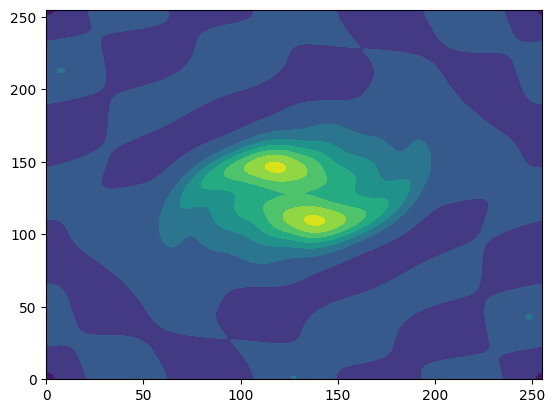

In [24]:
plt.contourf(w_gp)

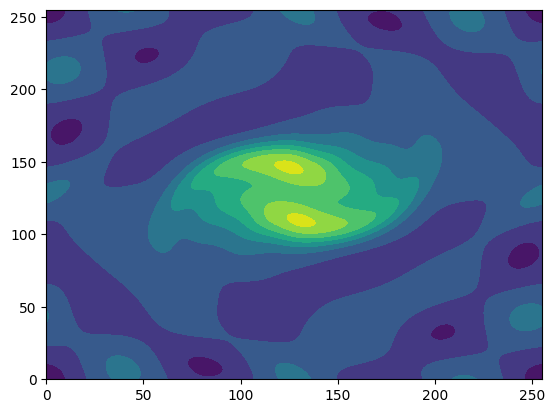

In [25]:
plt.contourf(w_test)

# Reference
https://arxiv.org/pdf/1910.13909.pdf

# To do 
* Compute the error due to simplification
* Compute the speed-up due to meta modeling
* Think about what can be done to improve the modlling